In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel("RetailX_Sales_Data (1).xlsx")

In [4]:
df.head()

,Date,StoreID,Region,ProductCategory,ProductID,UnitsSold,CustomerAgeGroup,CustomerGender,PromotionalCampaign,SeasonalEvent,DailySales
0,2023-01-01,1,North,Apparel,2002,17,26-35,Female,New Year Sale,New Year's Day,1700
1,2023-01-01,2,South,Home & Garden,3001,18,36-45,Other,New Year Sale,New Year's Day,1980
2,2023-01-01,3,East,Toys,4002,19,46-55,Male,New Year Sale,New Year's Day,2280
3,2023-01-02,1,North,Home & Garden,3001,17,36-45,Other,New Year Sale,New Year's Day,1700
4,2023-01-02,2,South,Toys,4002,19,46-55,Male,New Year Sale,New Year's Day,2090


In [5]:
df.shape

(2193, 11)

## Checking for missing values

In [6]:
df.isnull().sum()

Date                     0
StoreID                  0
Region                   0
ProductCategory          0
ProductID                0
UnitsSold                0
CustomerAgeGroup         0
CustomerGender           0
PromotionalCampaign    366
SeasonalEvent          372
DailySales               0
dtype: int64

In [7]:
df["PromotionalCampaign"].value_counts()

PromotionalCampaign
New Year Sale       372
Black Friday        366
Back to School      366
Winter Clearance    366
Summer Sale         357
Name: count, dtype: int64

In [8]:
df["SeasonalEvent"].value_counts()

SeasonalEvent
New Year's Day    546
Christmas         543
Easter            372
Halloween         360
Name: count, dtype: int64

In [9]:
df.head()

,Date,StoreID,Region,ProductCategory,ProductID,UnitsSold,CustomerAgeGroup,CustomerGender,PromotionalCampaign,SeasonalEvent,DailySales
0,2023-01-01,1,North,Apparel,2002,17,26-35,Female,New Year Sale,New Year's Day,1700
1,2023-01-01,2,South,Home & Garden,3001,18,36-45,Other,New Year Sale,New Year's Day,1980
2,2023-01-01,3,East,Toys,4002,19,46-55,Male,New Year Sale,New Year's Day,2280
3,2023-01-02,1,North,Home & Garden,3001,17,36-45,Other,New Year Sale,New Year's Day,1700
4,2023-01-02,2,South,Toys,4002,19,46-55,Male,New Year Sale,New Year's Day,2090


In [10]:
df["PromotionalCampaign"].value_counts()

PromotionalCampaign
New Year Sale       372
Black Friday        366
Back to School      366
Winter Clearance    366
Summer Sale         357
Name: count, dtype: int64

## Predictive imputation using RandomForest Classifier

In [11]:
# Encode categorical columns
label_encoders = {}
for column in ['Region', 'ProductCategory', 'CustomerAgeGroup', 'CustomerGender']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [12]:
# Prepare data for training
df_filtered_promo = df.dropna(subset=['PromotionalCampaign', 'SeasonalEvent'])
X_train_promo = df_filtered_promo[['Region', 'ProductCategory', 'CustomerAgeGroup', 'CustomerGender', 'DailySales']]
y_promo = df_filtered_promo['PromotionalCampaign']

In [13]:
# Train Random Forest model for PromotionalCampaign
rf_promo = RandomForestClassifier()
rf_promo.fit(X_train_promo, y_promo)

RandomForestClassifier()

In [14]:
# Prepare data for training SeasonalEvent
df_filtered_seasonal = df.dropna(subset=['PromotionalCampaign', 'SeasonalEvent'])
X_train_seasonal = df_filtered_seasonal[['Region', 'ProductCategory', 'CustomerAgeGroup', 'CustomerGender', 'DailySales']]
y_seasonal = df_filtered_seasonal['SeasonalEvent']

In [15]:
# Train Random Forest model for SeasonalEvent
rf_seasonal = RandomForestClassifier()
rf_seasonal.fit(X_train_seasonal, y_seasonal)

RandomForestClassifier()

In [16]:
# Impute missing values using trained models
for index, row in df.iterrows():
    if pd.isnull(row['PromotionalCampaign']):
        X_pred = row[['Region', 'ProductCategory', 'CustomerAgeGroup', 'CustomerGender', 'DailySales']].values.reshape(1, -1)
        imputed_value = rf_promo.predict(X_pred)[0]
        df.at[index, 'PromotionalCampaign'] = imputed_value
    
    if pd.isnull(row['SeasonalEvent']):
        X_pred = row[['Region', 'ProductCategory', 'CustomerAgeGroup', 'CustomerGender', 'DailySales']].values.reshape(1, -1)
        imputed_value = rf_seasonal.predict(X_pred)[0]
        df.at[index, 'SeasonalEvent'] = imputed_value

In [17]:
# Decode categorical columns
for column in ['Region', 'ProductCategory', 'CustomerAgeGroup', 'CustomerGender']:
    df[column] = label_encoders[column].inverse_transform(df[column])

In [18]:
df["PromotionalCampaign"].value_counts()

PromotionalCampaign
Black Friday        530
Summer Sale         473
New Year Sale       458
Back to School      366
Winter Clearance    366
Name: count, dtype: int64

In [19]:
df["SeasonalEvent"].value_counts()

SeasonalEvent
New Year's Day    646
Christmas         623
Easter            476
Halloween         448
Name: count, dtype: int64

## Checking for duplicate rows and records

In [20]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

In [21]:
# Display duplicate rows
print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
Empty DataFrame
Columns: [Date, StoreID, Region, ProductCategory, ProductID, UnitsSold, CustomerAgeGroup, CustomerGender, PromotionalCampaign, SeasonalEvent, DailySales]
Index: []


# Performing Exploratory data analysis

## Region-wise sales and units sold

In [22]:
# Group by Region and calculate the sum of sales and units sold
region_sum = df.groupby('Region').agg({'DailySales': 'sum', 'UnitsSold': 'sum'}).reset_index()

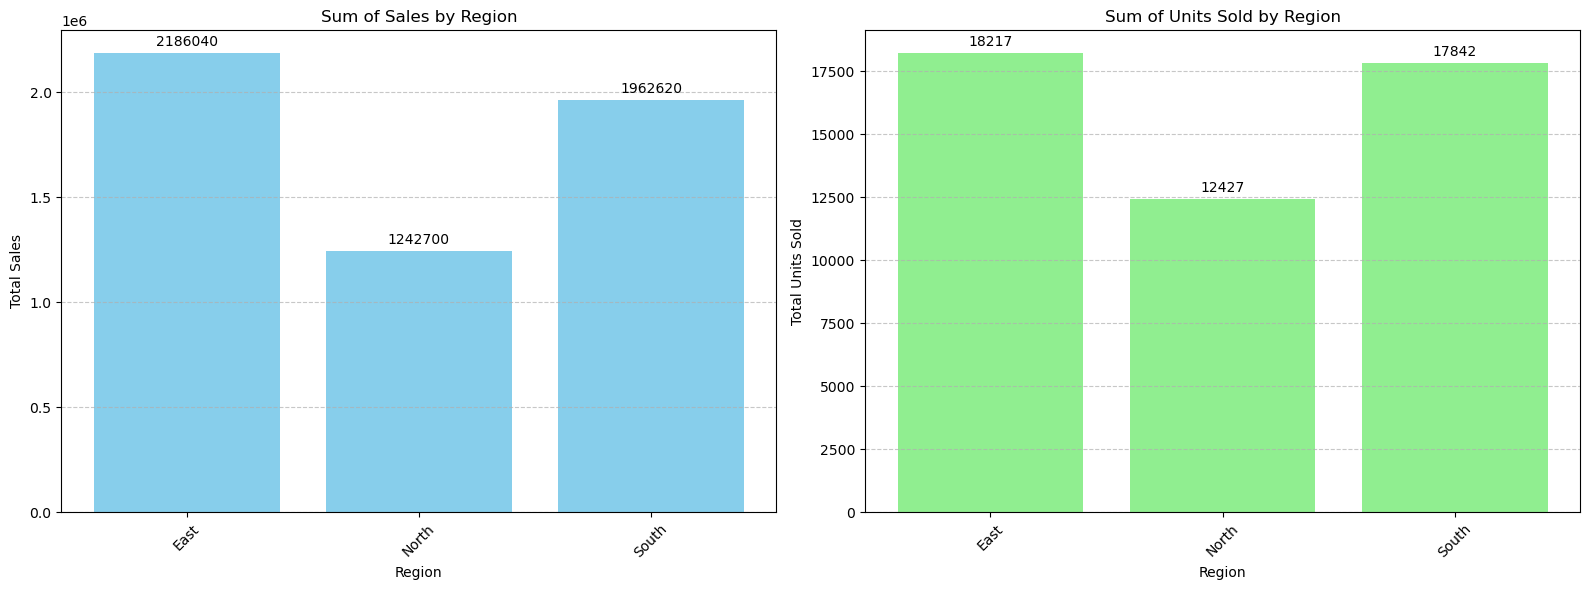

In [23]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot Total Sales by Region
sales_bars = axs[0].bar(region_sum['Region'], region_sum['DailySales'], color='skyblue')
axs[0].set_xlabel('Region')
axs[0].set_ylabel('Total Sales')
axs[0].set_title('Sum of Sales by Region')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Annotate Total Sales on top of each bar
for bar in sales_bars:
    height = bar.get_height()
    axs[0].annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plot Total Units Sold by Region
units_bars = axs[1].bar(region_sum['Region'], region_sum['UnitsSold'], color='lightgreen')
axs[1].set_xlabel('Region')
axs[1].set_ylabel('Total Units Sold')
axs[1].set_title('Sum of Units Sold by Region')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Annotate Total Units Sold on top of each bar
for bar in units_bars:
    height = bar.get_height()
    axs[1].annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Store-wise sales and units sold

In [24]:
# Group by StoreID and calculate the sum of sales and units sold
store_sum = df.groupby('StoreID').agg({'DailySales': 'sum', 'UnitsSold': 'sum'}).reset_index()

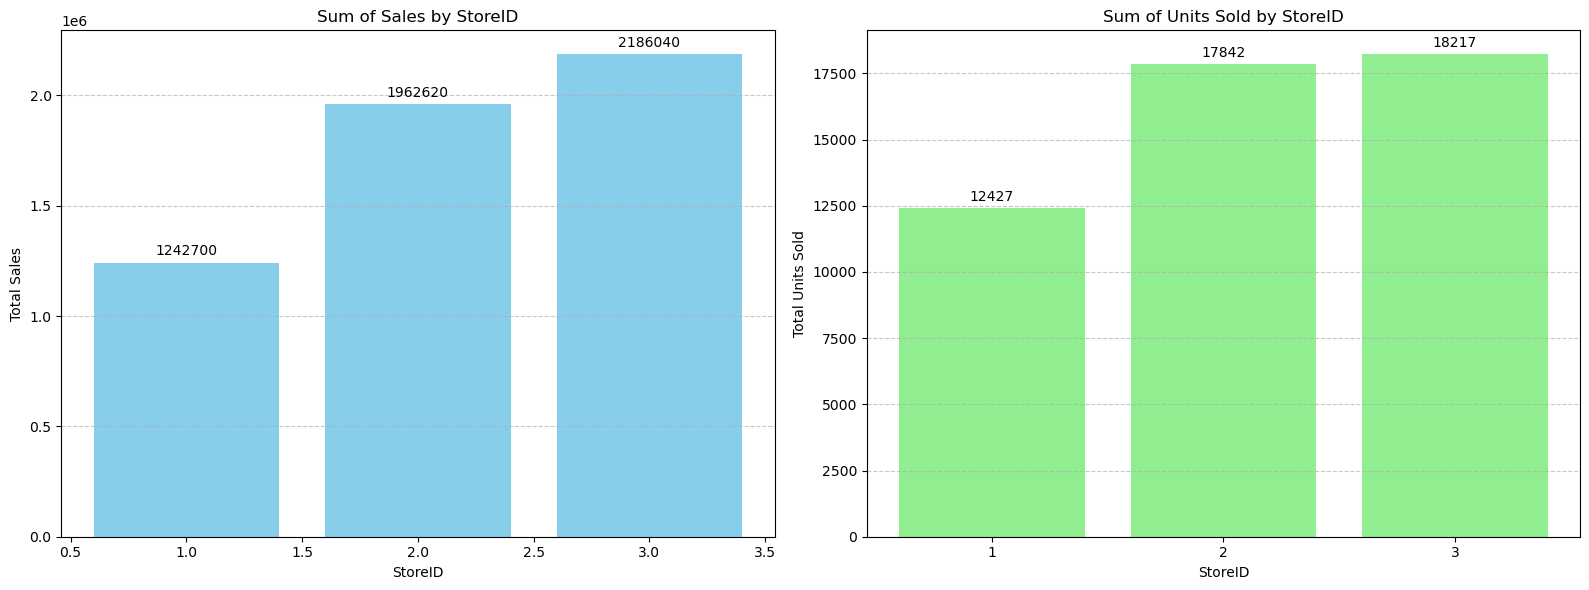

In [25]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot Total Sales by StoreID
sales_bars = axs[0].bar(store_sum['StoreID'], store_sum['DailySales'], color='skyblue')
axs[0].set_xlabel('StoreID')
axs[0].set_ylabel('Total Sales')
axs[0].set_title('Sum of Sales by StoreID')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Annotate Total Sales on top of each bar
for bar in sales_bars:
    height = bar.get_height()
    axs[0].annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plot Total Units Sold by StoreID
units_bars = axs[1].bar(store_sum['StoreID'], store_sum['UnitsSold'], color='lightgreen')
axs[1].set_xlabel('StoreID')
axs[1].set_ylabel('Total Units Sold')
axs[1].set_title('Sum of Units Sold by StoreID')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Annotate Total Units Sold on top of each bar
for bar in units_bars:
    height = bar.get_height()
    axs[1].annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Set x-axis ticks to only 1, 2, 3
plt.xticks(store_sum['StoreID'])

plt.tight_layout()
plt.show()

## Sales trends across product categories and seasons

In [26]:
# Group by ProductCategory and Season, calculate total sales
sales_by_category_season = df.groupby(['ProductCategory', 'SeasonalEvent']).agg({'DailySales': 'sum'}).reset_index()

# Pivot the data for easier plotting
sales_pivot = sales_by_category_season.pivot(index='SeasonalEvent', columns='ProductCategory', values='DailySales')

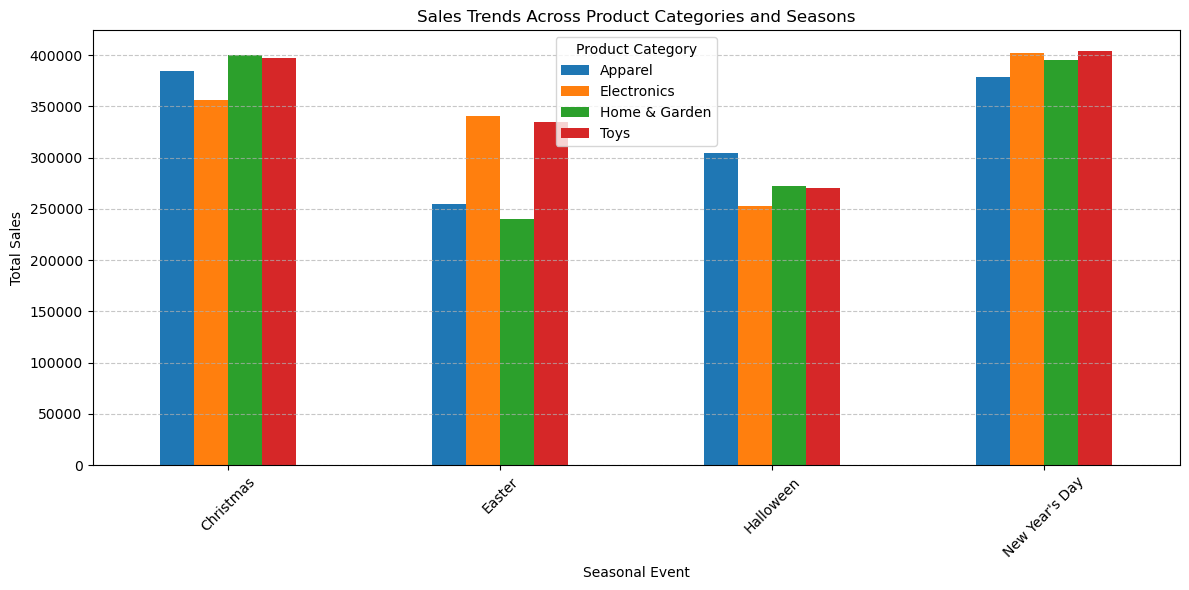

In [27]:
# Plotting
sales_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Sales Trends Across Product Categories and Seasons')
plt.xlabel('Seasonal Event')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Product Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Total sales by promotional campaign

In [28]:
# Calculate total sales for each promotional campaign
promo_sales = df.groupby('PromotionalCampaign')['DailySales'].sum().reset_index()

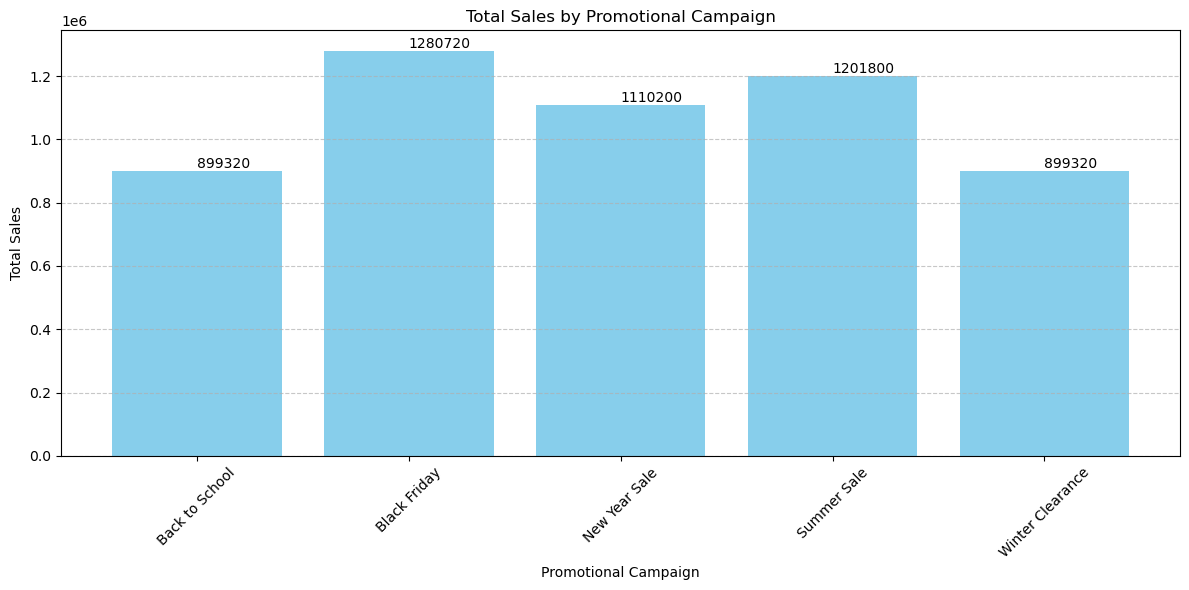

In [29]:
# Visualize the impact of promotional campaigns on sales for each product category
plt.figure(figsize=(12, 6))
bars = plt.bar(promo_sales['PromotionalCampaign'], promo_sales['DailySales'], color='skyblue')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), va='bottom')

plt.xlabel('Promotional Campaign')
plt.ylabel('Total Sales')
plt.title('Total Sales by Promotional Campaign')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Total sales by seasonal event

In [30]:
# Group the data by ProductCategory and SeasonalEvent and calculate total sales
sales_by_category_event = df.groupby(['ProductCategory', 'PromotionalCampaign'])['DailySales'].sum().reset_index()

In [31]:
# Pivot the data for better visualization
sales_pivot = sales_by_category_event.pivot(index='ProductCategory', columns='PromotionalCampaign', values='DailySales')

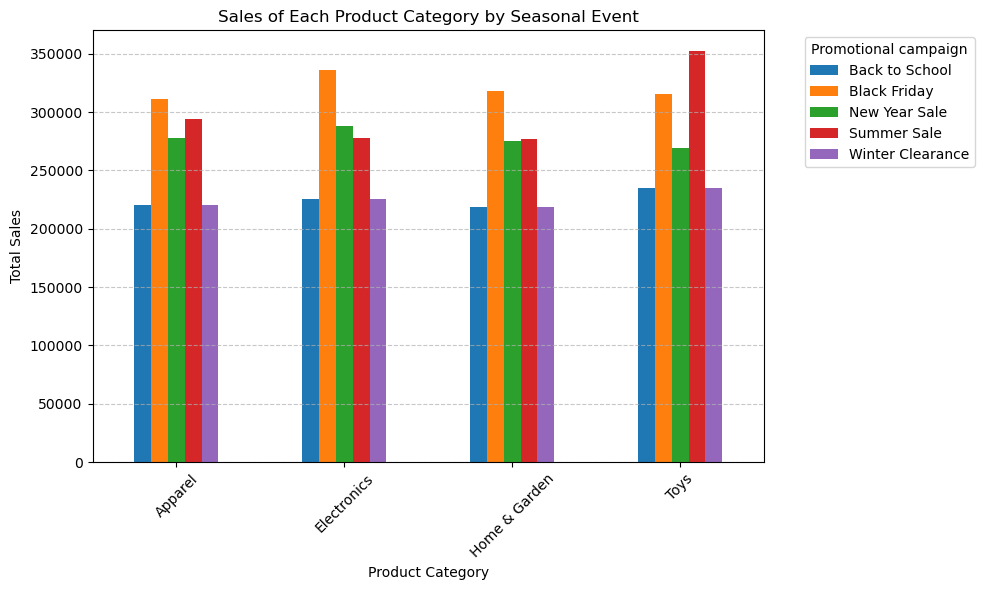

In [32]:
# Plot the sales of each product category with respect to the seasonal event
sales_pivot.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.title('Sales of Each Product Category by Seasonal Event')
plt.xticks(rotation=45)
plt.legend(title='Promotional campaign', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()